In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
df = pd.read_csv('card_transaction_EDA.csv')
df.head(5)

,customerId,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,isMatchedCVV
0,737265056,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,PURCHASE,0.0,False,False,False,True
1,737265056,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,PURCHASE,0.0,True,False,False,True
2,737265056,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,PURCHASE,0.0,False,False,False,True
3,737265056,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,PURCHASE,0.0,False,False,False,True
4,830329091,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,PURCHASE,0.0,True,False,False,True


In [159]:
#Convert transactionDateTime from categorical to datetime type
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customerId                786363 non-null  int64         
 1   availableMoney            786363 non-null  float64       
 2   transactionDateTime       786363 non-null  datetime64[ns]
 3   transactionAmount         786363 non-null  float64       
 4   merchantName              786363 non-null  object        
 5   acqCountry                786363 non-null  object        
 6   merchantCountryCode       786363 non-null  object        
 7   posEntryMode              786363 non-null  object        
 8   posConditionCode          786363 non-null  object        
 9   merchantCategoryCode      786363 non-null  object        
 10  currentExpDate            786363 non-null  object        
 11  accountOpenDate           786363 non-null  object        
 12  da

### Handling duplicated reversal transactions

There are 2 types of duplicated transactions in this dataset:
- duplicates of reversed transaction, where a purchase is followed by a reversal. 
- multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

I will identify these transactions and calculate total number and total dollar amount of them.


In [163]:
print("Number of reversal transactions: ", df[df['transactionType']=='REVERSAL'].shape[0])

Number of reversal transactions:  20303


In [164]:
# Filter reversal transactions
df_reversal = df[df['transactionType'] == 'REVERSAL']

# Sort by relevant features
df_reversal = df_reversal.sort_values(by=['customerId', 'merchantName', 'transactionAmount', 'transactionDateTime'])

# Group by key features
group_cols = ['customerId', 'merchantName', 'transactionAmount']

# Calculate previous time
df_reversal['prev_time'] = df_reversal.groupby(group_cols, observed=False)['transactionDateTime'].shift(1)

# Calculate time difference in minutes
df_reversal['time_diff_min'] = (df_reversal['transactionDateTime'] - df_reversal['prev_time']).dt.total_seconds() / 60

# Flag potential duplicates
df_reversal['isDupReversal'] = df_reversal['time_diff_min'].between(0, 10)

# View only those duplicates
df_reversal[df_reversal['isDupReversal']].shape

(0, 22)

In [165]:
#Calculate total amount of duplicated reversal transactions
(df_reversal[df_reversal['isDupReversal']]['transactionAmount']).sum()

0.0

In [166]:

# Filter non-reversal transactions
df_multi_swipe = df[df['transactionType'] != 'REVERSAL']

# Sort by relevant features
df_multi_swipe = df_multi_swipe.sort_values(by=['customerId', 'merchantName', 'transactionAmount', 'transactionDateTime'])

# Group by key features
group_cols = ['customerId', 'merchantName', 'transactionAmount']

# Calculate previous time
df_multi_swipe['prev_time'] = df_multi_swipe.groupby(group_cols, observed=False)['transactionDateTime'].shift(1)

# Calculate time difference in minutes
df_multi_swipe['time_diff_min'] = (df_multi_swipe['transactionDateTime'] - df_multi_swipe['prev_time']).dt.total_seconds() / 60

# Flag potential duplicates
df_multi_swipe['isMultiSwipe'] = df_multi_swipe['time_diff_min'].between(0, 10)

# View only those duplicates
df_multi_swipe[df_multi_swipe['isMultiSwipe']].shape

(7682, 22)

In [167]:
#Calculate total amount of duplicated transactions
(df_multi_swipe[df_multi_swipe['isMultiSwipe']]['transactionAmount']).sum()

1104217.97

### Handling DateTime

Let's take a look as these datetime features:
- transactionDateTime
- currentExpDate
- accountOpenDate
- dateOfLastAddressChange


In [170]:
df[['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']].head(5)

,transactionDateTime,currentExpDate,accountOpenDate,dateOfLastAddressChange
0,2016-08-13 14:27:32,06/2023,2015-03-14,2015-03-14
1,2016-10-11 05:05:54,02/2024,2015-03-14,2015-03-14
2,2016-11-08 09:18:39,08/2025,2015-03-14,2015-03-14
3,2016-12-10 02:14:50,08/2025,2015-03-14,2015-03-14
4,2016-03-24 21:04:46,10/2029,2015-08-06,2015-08-06


These should be transformed into a more algorithm friendly format. I will create new columns to calculate age of card, days until expiration, and days since address change so that we can use for analysis and prediction. I will then drop original columns.

In [172]:
#Calculate the age of card in terms of days
df['cardAge'] = df['transactionDateTime'] - pd.to_datetime(df['accountOpenDate'])
df['cardAge'] = df['cardAge'].dt.days

In [173]:
#Summary statistic of cardAge
df.groupby('isFraud')['cardAge'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,773946.0,884.053782,697.801168,1.0,430.0,680.0,1110.0,9990.0
True,12417.0,851.049770,677.999851,12.0,427.0,667.0,1007.0,9890.0


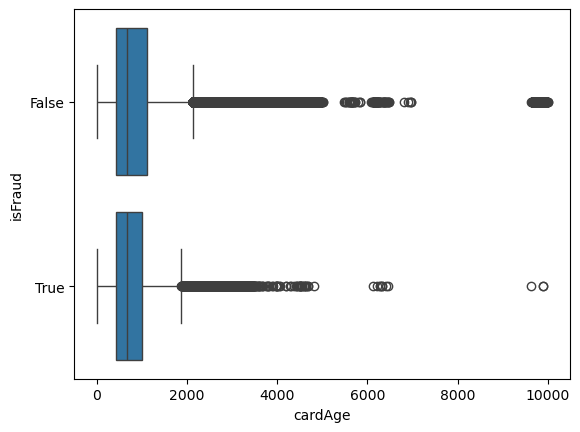

In [174]:
sns.boxplot(x='cardAge', y='isFraud', data=df, orient="h")
plt.show()

In [176]:
#Convert expiration date to datetime and align it to the end of the month

df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], format='mixed', errors='coerce') + pd.offsets.MonthEnd(0)

#Calculate number of days from transaction date until card expiration
df['cardExpiration'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days


In [178]:
#Summary statistic of cardExpiration
df.groupby('isFraud')['cardExpiration'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,773946.0,3762.548523,1446.263209,1095.0,2512.0,3767.0,5012.0,6451.0
True,12417.0,3783.092454,1444.838922,1099.0,2559.0,3789.0,5033.0,6438.0


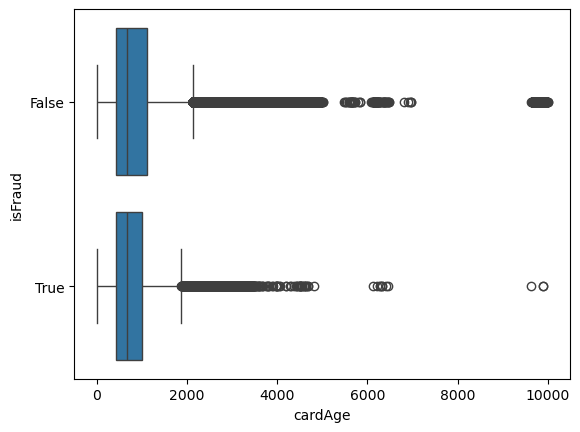

In [180]:
sns.boxplot(x='cardAge', y='isFraud', data=df, orient="h")
plt.show()

In [182]:
#Calculate days since last address change
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
df['daysSinceAddressChange'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days

In [184]:
#Summary statistic of cardAge
df.groupby('isFraud')['daysSinceAddressChange'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,773946.0,448.798443,663.797336,0.0,29.0,160.0,613.0,9990.0
True,12417.0,417.214545,656.859475,0.0,24.0,127.0,557.0,9890.0


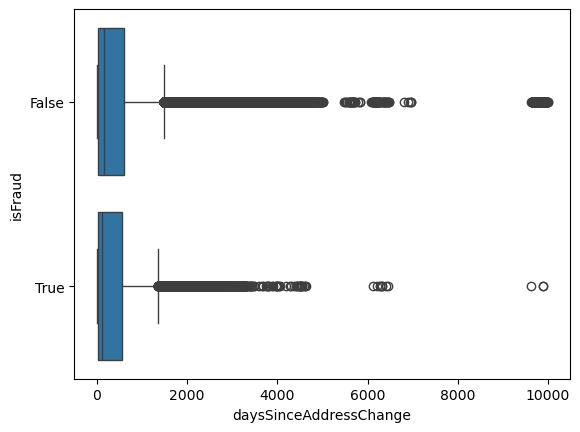

In [186]:
sns.boxplot(x='daysSinceAddressChange', y='isFraud', data=df, orient="h")
plt.show()

In [188]:
#Drop original columns
df = df.drop(columns=['currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime'], axis=1)

In [194]:
corr = df[['cardAge', 'cardExpiration', 'daysSinceAddressChange']].corr()
corr.style.background_gradient()

,cardAge,cardExpiration,daysSinceAddressChange
cardAge,1.000000,-0.013491,0.585585
cardExpiration,-0.013491,1.000000,0.003809
daysSinceAddressChange,0.585585,0.003809,1.000000


In [205]:
df.nunique() 

customerId                    5000
availableMoney              521888
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
transactionType                  4
currentBalance              487318
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
isMatchedCVV                     2
cardAge                       5102
cardExpiration                5356
daysSinceAddressChange        4810
dtype: int64

I will drop merchantName and customerId because of high cardinality.

In [208]:
df = df.drop(columns=['customerId', 'merchantName'], axis=1)

### Variable Encoding

I will use pd.get_dummies to one hot encode our categorical variables